In [48]:
import os
import glob
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate



Questionnaire results


/Users/human/.local/share/virtualenvs/nirs-analysis-cPFDHTrY/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trial_count,image,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,0713_1.jpg,5,5,5,5,5,4,5,5,3
1,2,0713_2.jpg,3,3,3,3,3,3,3,2,3
2,3,0713_3.jpg,2,2,3,2,3,3,3,2,1
3,4,0713_4.jpg,2,2,3,2,3,3,2,2,2
4,5,0713_5.jpg,4,4,4,4,4,4,4,4,4
5,6,0713_6.jpg,5,5,5,5,5,3,5,5,4
6,7,0713_7.jpg,3,4,4,4,4,3,3,3,3
7,8,0713_8.jpg,2,1,2,2,2,2,3,2,1
8,9,0713_9.jpg,1,1,3,2,2,3,2,1,1
9,10,0713_10.jpg,4,4,4,4,4,4,4,4,4




Questionnaire contents


,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,退屈な-面白い,嫌い-好き,不快-快,豊かでない-豊かである,ポジティブでない-ポジティブである,暗い-明るい,弱々しい-力強い,平凡な-独創的な,理性的な-感情的な




Oxy-Hb data


,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0.000,0,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.150,0,,-0.010916,0.003867,0.006667,0.003237,0.002989,0.004922,0.004623,...,0.008919,0.003507,0.005177,0.002709,0.007292,0.003441,0.003417,0.008807,0.006464,0.002820
2,0.300,0,,0.001431,0.003377,0.007147,0.003741,0.002111,0.003658,0.005710,...,0.010347,0.002795,0.005039,0.005042,0.006374,0.002175,0.002802,0.010716,0.006633,0.002474
3,0.450,0,,-0.002045,0.001742,0.004772,0.002395,-0.003275,0.000927,0.003333,...,0.006198,0.000844,0.003133,0.001365,0.002798,0.000594,0.000109,0.007197,0.003833,-0.000237
4,0.600,0,,0.001474,0.000238,0.000823,-0.000762,-0.005549,-0.002680,-0.000588,...,0.000255,-0.001728,-0.001860,0.001166,-0.001348,-0.001288,-0.002298,0.002399,-0.000579,-0.002828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,1737.3,10,questionnaire,-0.071698,-0.058509,-0.042237,0.033209,-0.065773,0.063947,0.073778,...,-0.037005,-0.027884,0.006887,-0.015162,-0.029784,-0.028576,-0.009314,-0.061780,-0.001060,0.070055
11583,1737.45,10,questionnaire,-0.064951,-0.058814,-0.042617,0.030935,-0.067479,0.064016,0.071132,...,-0.040981,-0.027485,0.007266,-0.015991,-0.031610,-0.030835,-0.010556,-0.059402,-0.003844,0.067960
11584,1737.6,10,questionnaire,-0.066047,-0.060842,-0.045839,0.026885,-0.071183,0.065581,0.068064,...,-0.047664,-0.030606,0.004814,-0.017076,-0.035312,-0.032719,-0.011985,-0.054567,-0.009187,0.066070
11585,1737.75,10,questionnaire,-0.073903,-0.063848,-0.049477,0.024036,-0.073848,0.067346,0.066408,...,-0.053574,-0.032306,0.001804,-0.023427,-0.040371,-0.037321,-0.015537,-0.048710,-0.014751,0.063313




Denoised Oxy-Hb data


,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0.000,0,,-0.00464276,0.00223329,0.0139492,0.0040958,-0.0237375,-0.00588489,0.0296848,...,0.0128916,0.001705,0.0319719,0.0151213,0.0134458,-0.00615219,0.00640047,0.0238942,0.00897636,0.0233004
1,0.150,0,,-0.00449018,0.00235836,0.0141035,0.00421186,-0.0236464,-0.00576329,0.0300291,...,0.0129335,0.00186504,0.0324057,0.015248,0.0136592,-0.00612933,0.0064919,0.0239671,0.00905107,0.0237759
2,0.300,0,,-0.00434144,0.00248051,0.0142545,0.00432573,-0.0235596,-0.00564566,0.0303682,...,0.0129731,0.00202117,0.0328337,0.0153728,0.0138689,-0.00610833,0.00658189,0.0240396,0.00912243,0.0242438
3,0.450,0,,-0.00419654,0.00259976,0.0144022,0.00443741,-0.023477,-0.00553197,0.0307021,...,0.0130106,0.00217342,0.033256,0.0154956,0.0140749,-0.00608917,0.00667043,0.0241118,0.00919045,0.0247039
4,0.600,0,,-0.00405545,0.00271611,0.0145468,0.00454693,-0.0233986,-0.00542219,0.0310308,...,0.0130458,0.0023218,0.0336726,0.0156165,0.0142773,-0.00607184,0.00675755,0.0241836,0.00925516,0.0251564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,1737.3,10,questionnaire,-0.149026,-0.124629,-0.0822625,0.0669176,-0.167445,0.0592242,0.19498,...,-0.058923,-0.0329402,0.0129868,0.0355423,-0.0300857,-0.0511293,-0.0420304,-0.154537,0.0487797,0.143932
11583,1737.45,10,questionnaire,-0.148447,-0.124255,-0.0820718,0.0666911,-0.166835,0.0589829,0.194171,...,-0.0589226,-0.032995,0.0129001,0.0352455,-0.0301557,-0.0510632,-0.0418375,-0.154176,0.0483313,0.14333
11584,1737.6,10,questionnaire,-0.147868,-0.123879,-0.081879,0.066464,-0.166223,0.0587414,0.193362,...,-0.0589191,-0.0330476,0.0128135,0.0349508,-0.0302231,-0.050995,-0.0416446,-0.153811,0.0478857,0.142728
11585,1737.75,10,questionnaire,-0.147287,-0.1235,-0.0816839,0.0662363,-0.16561,0.0584996,0.192552,...,-0.0589123,-0.0330978,0.012727,0.0346582,-0.0302877,-0.0509246,-0.0414516,-0.153442,0.0474429,0.142124




Trial count -> 1


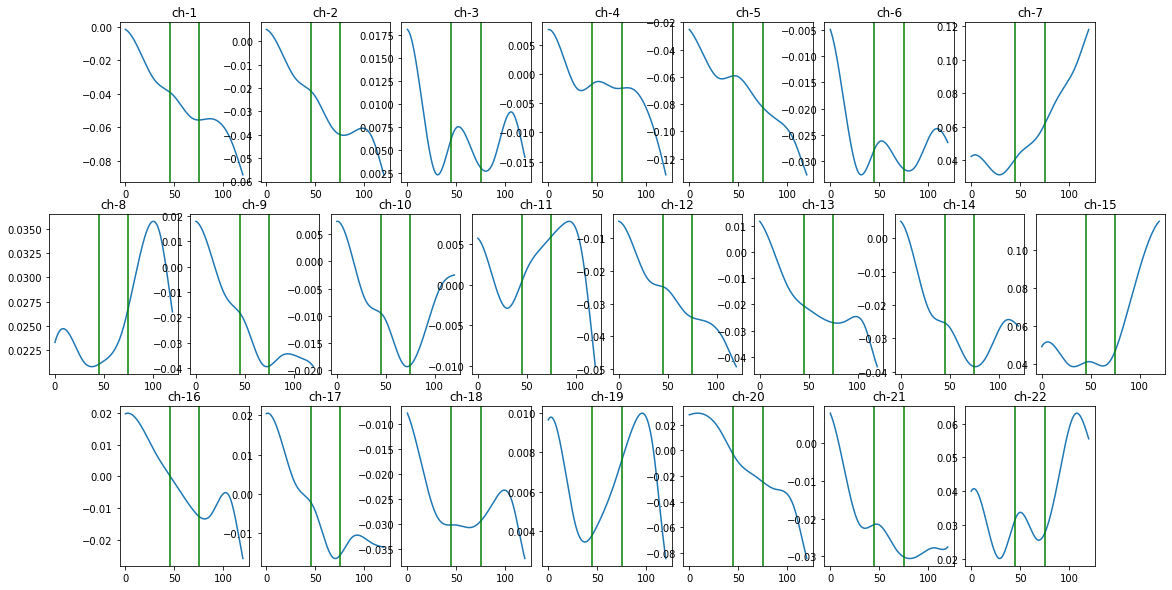

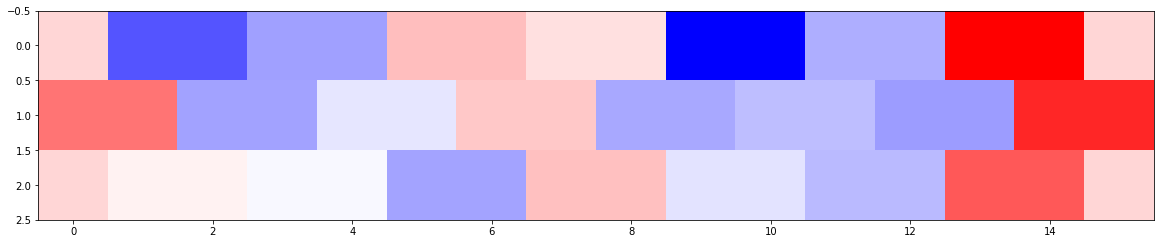



Trial count -> 2


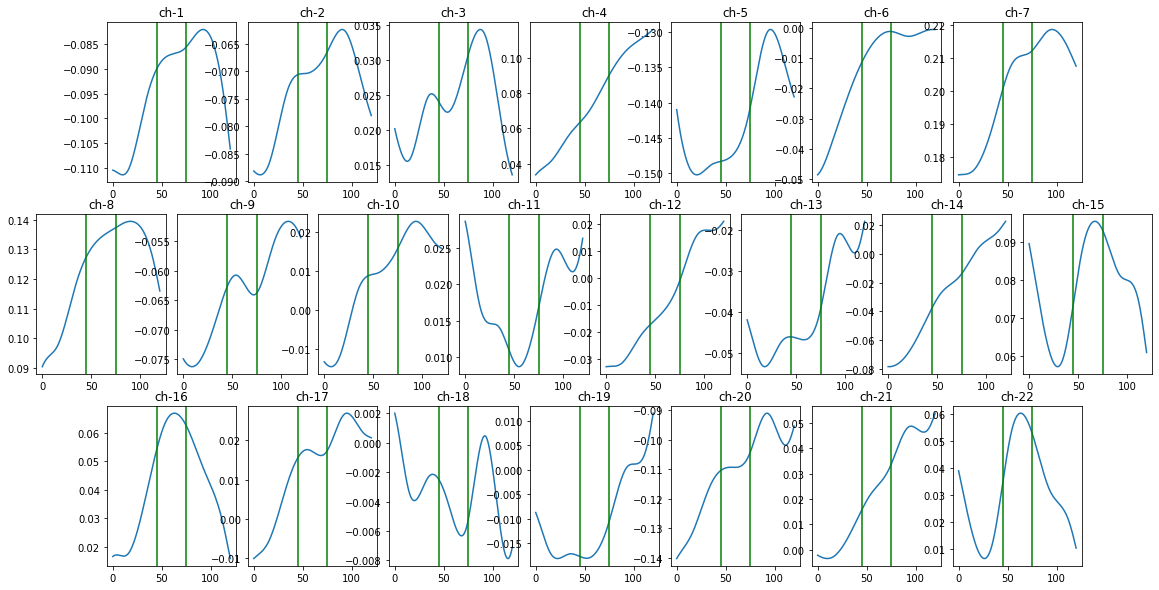

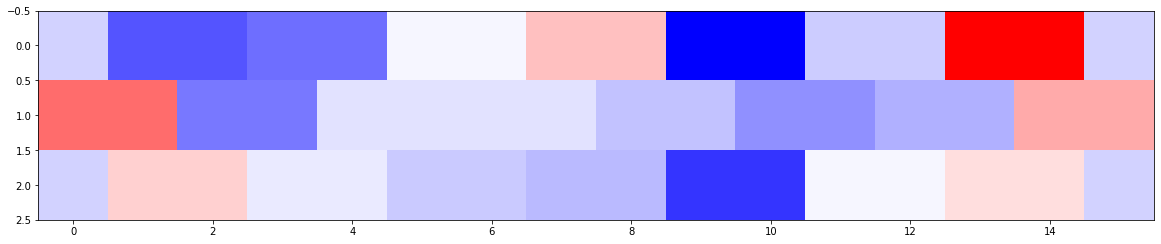



Trial count -> 3


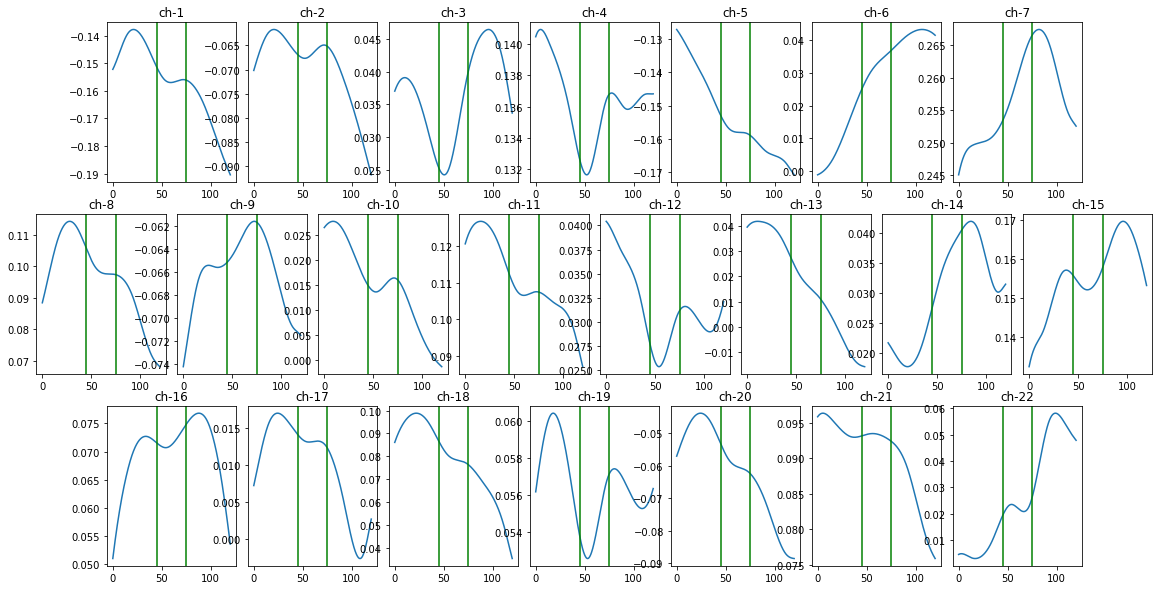

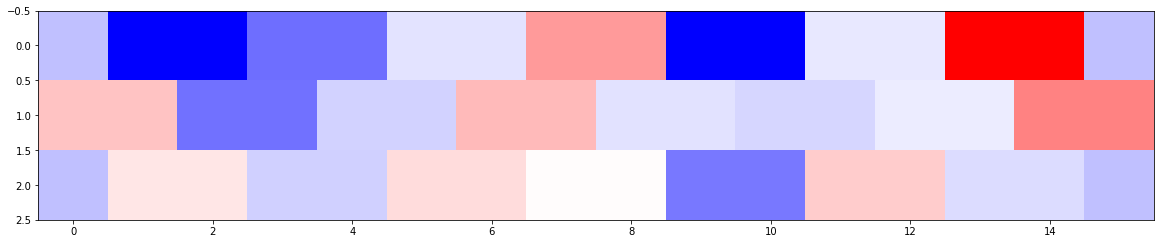



Trial count -> 4


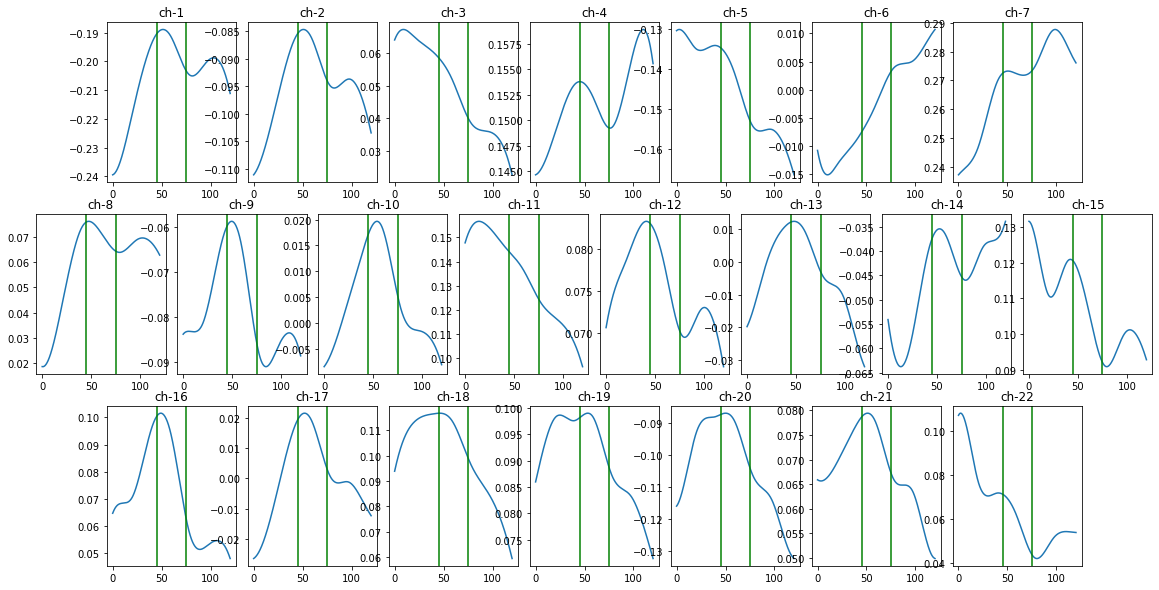

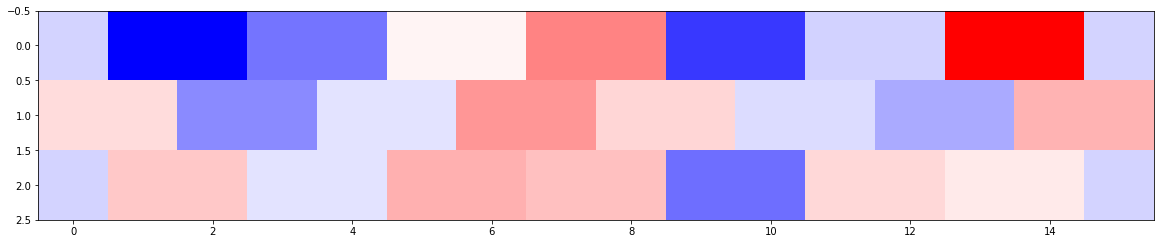



Trial count -> 5


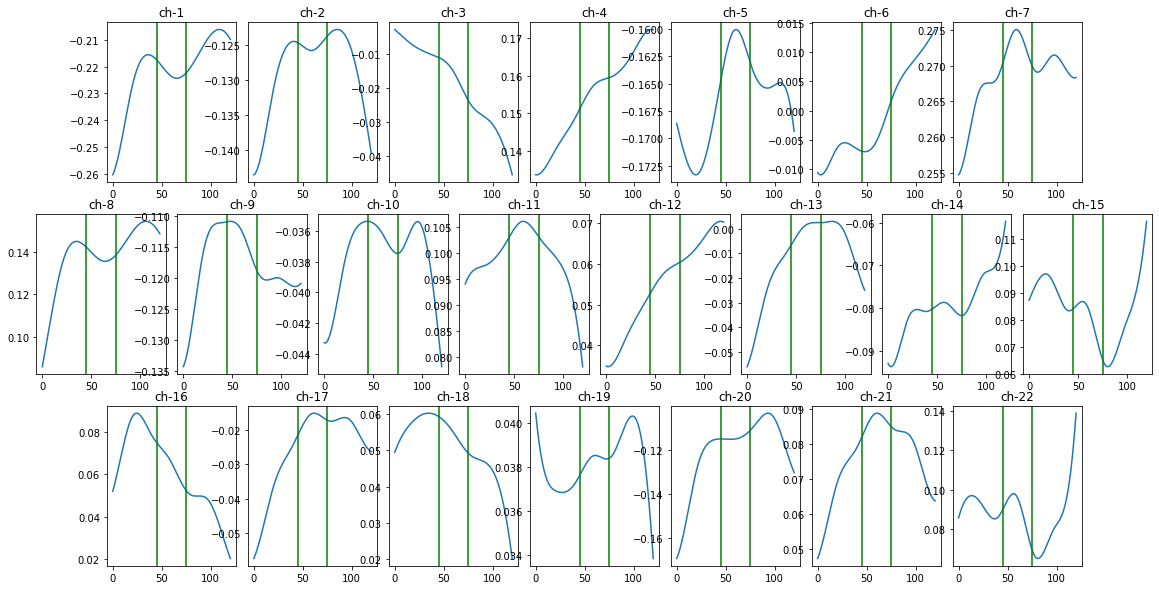

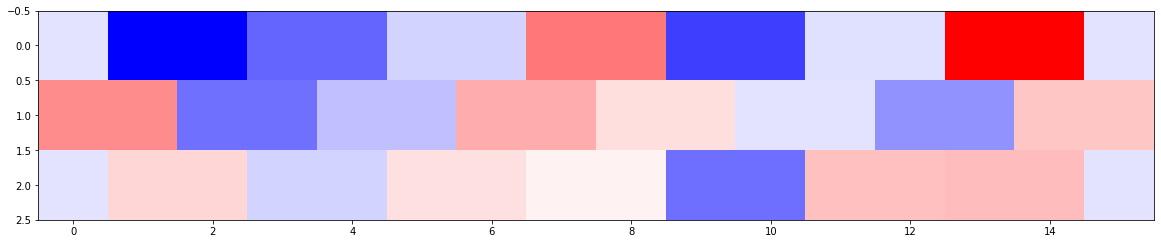



Trial count -> 6


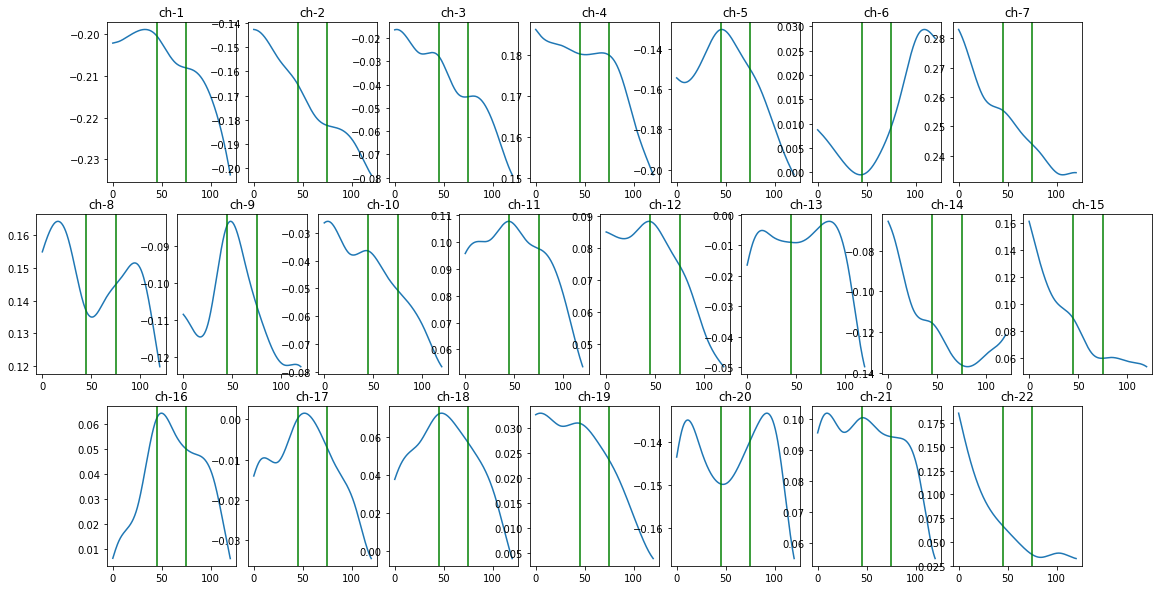

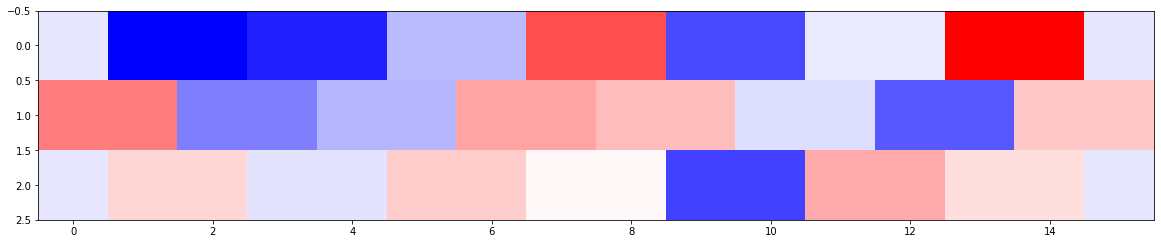



Trial count -> 7


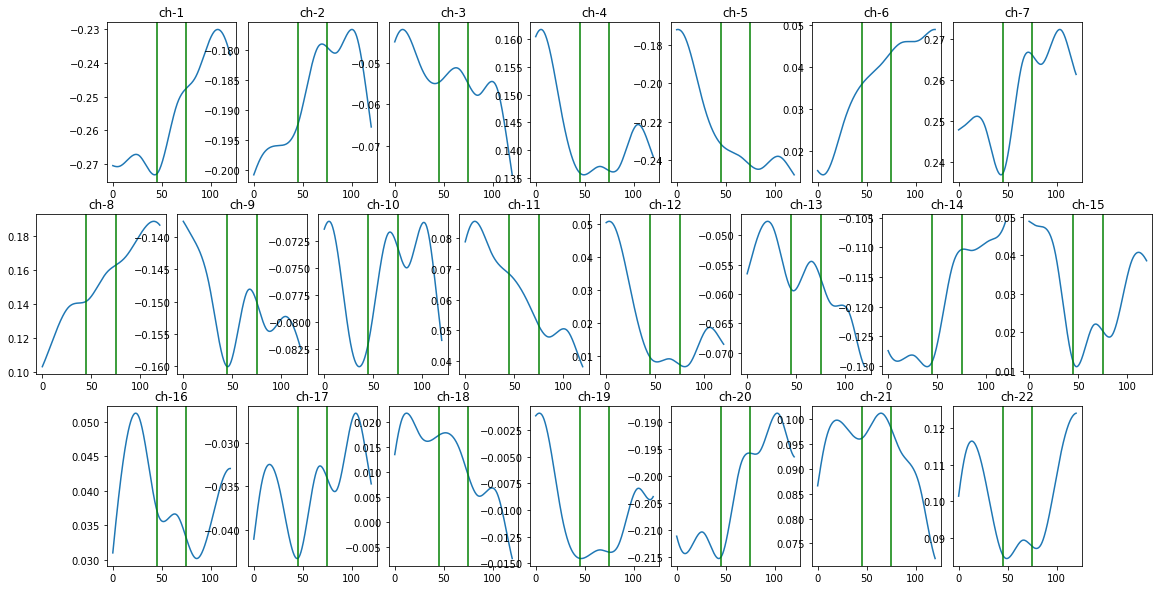

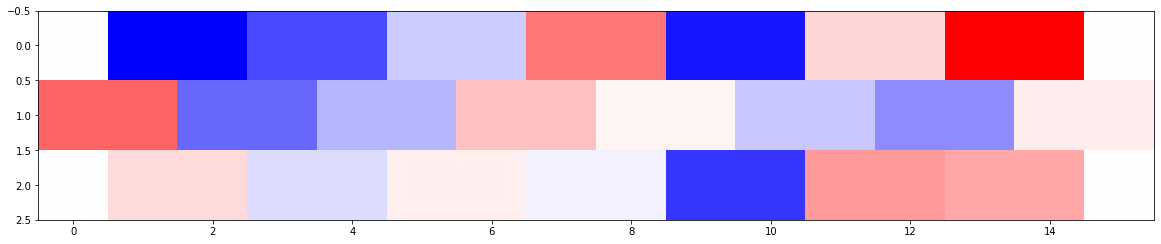



Trial count -> 8


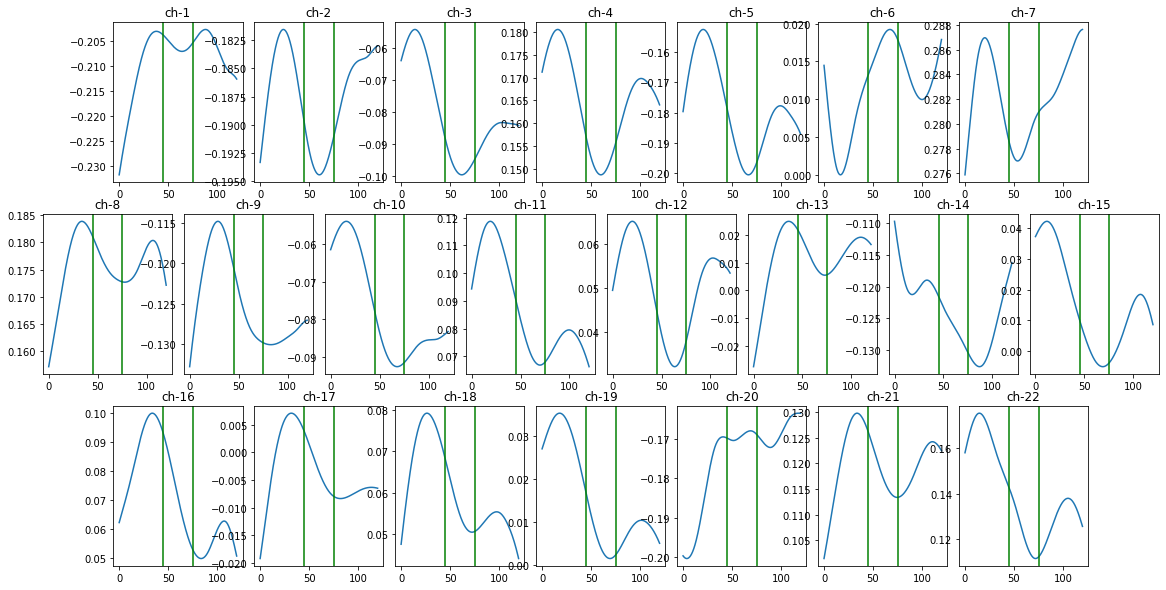

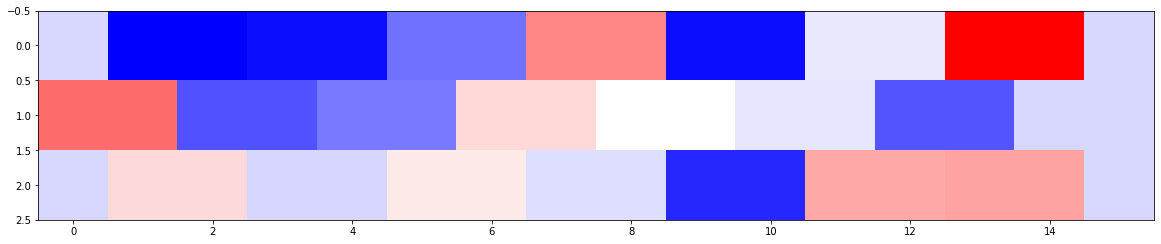



Trial count -> 9


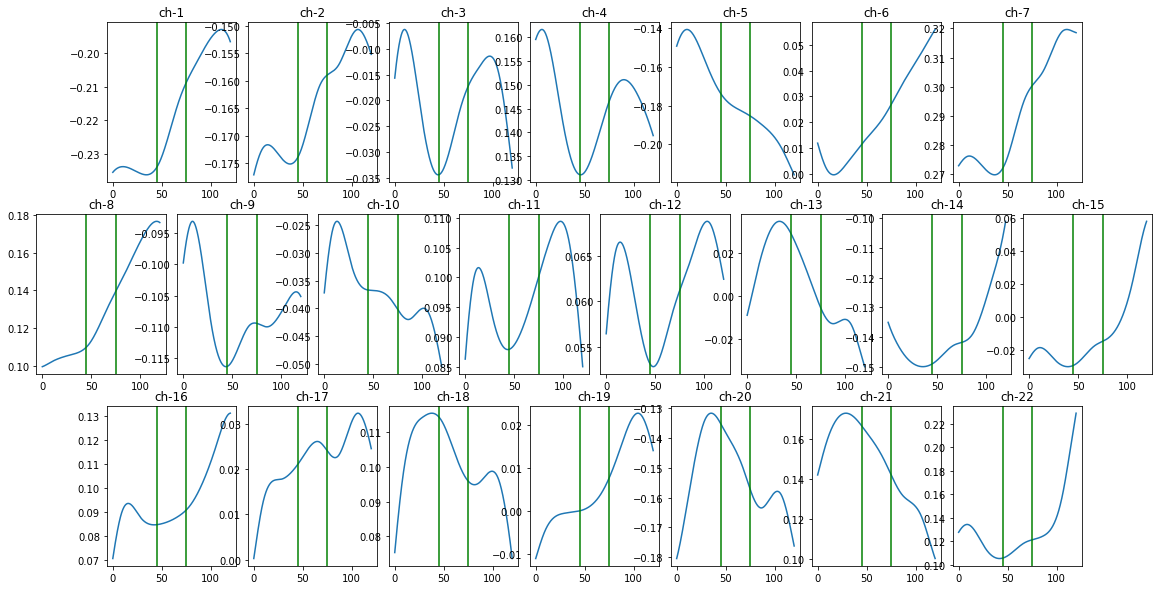

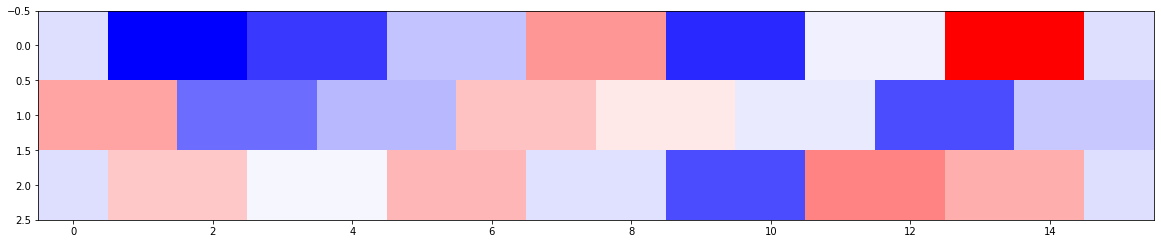



Trial count -> 10


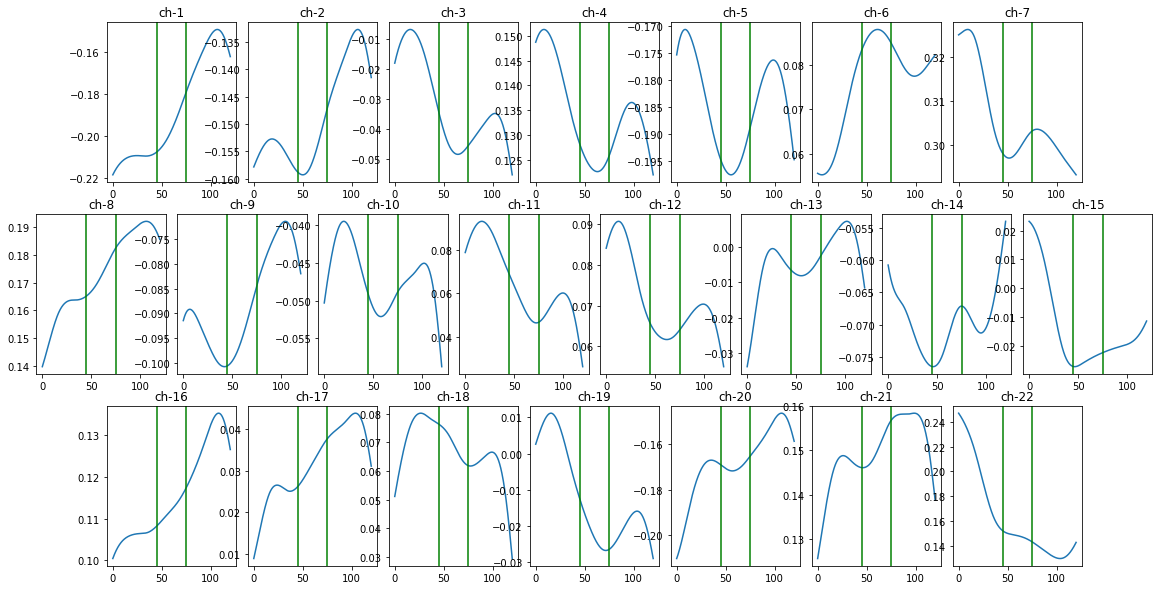

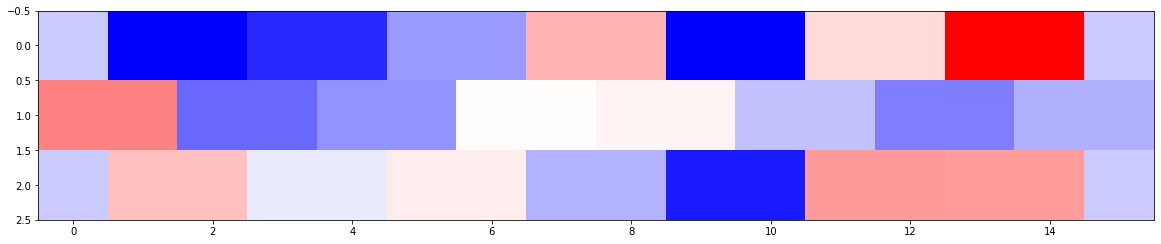



Z-normalized Oxy-Hb data


,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,54.450,1,task,1.73083,1.71902,1.70708,1.69501,1.6828,1.67045,1.65796,...,1.57969,1.56606,1.55225,1.53826,1.52408,1.50971,1.49514,1.48038,1.46541,1.45023
1,54.600,1,task,1.43484,1.41924,1.40341,1.38736,1.37109,1.35461,1.33791,...,1.23352,1.21546,1.19721,1.1788,1.16021,1.14146,1.12254,1.10347,1.08424,1.06487
2,54.750,1,task,1.04535,1.02568,1.00588,0.985951,0.96589,0.945703,0.925396,...,0.801254,0.780219,0.759097,0.737892,0.716607,0.695248,0.673818,0.652321,0.630762,0.609145
3,54.900,1,task,0.587474,0.565752,0.543985,0.522176,0.500329,0.478449,0.45654,...,0.324703,0.302706,0.280712,0.258726,0.236753,0.214796,0.19286,0.170948,0.149065,0.127216
4,55.050,1,task,0.105403,0.0836319,0.0619061,0.04023,0.0186076,-0.00295689,-0.0244593,...,-0.151938,-0.172889,-0.193746,-0.214503,-0.235156,-0.255702,-0.276136,-0.296454,-0.316651,-0.336724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1644.75,10,task,0.254586,0.242603,0.230534,0.218374,0.206121,0.193771,0.181323,...,0.104368,0.0911363,0.07778,0.0642961,0.0506816,0.0369334,0.0230482,0.00902304,-0.00514525,-0.0194598
1996,1644.9,10,task,-0.0339237,-0.0485402,-0.0633123,-0.0782431,-0.0933358,-0.108593,-0.124019,...,-0.22028,-0.23697,-0.253853,-0.270933,-0.288212,-0.305693,-0.32338,-0.341276,-0.359383,-0.377706
1997,1645.05,10,task,-0.396247,-0.415009,-0.433995,-0.453209,-0.472653,-0.492331,-0.512246,...,-0.636884,-0.658544,-0.680467,-0.702654,-0.725109,-0.747835,-0.770836,-0.794113,-0.817667,-0.841495
1998,1645.2,10,task,-0.865597,-0.889971,-0.914615,-0.939528,-0.96471,-0.990158,-1.01587,...,-1.17564,-1.20317,-1.23096,-1.259,-1.28729,-1.31583,-1.34462,-1.37365,-1.40293,-1.43246




Oxy-Hb mean with questionnaire results


,trial_count,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,image,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,-0.048732,-0.031264,0.005898,-0.001875,-0.068682,-0.028141,0.050119,0.022950,-0.030982,...,0713_1.jpg,5,5,5,5,5,4,5,5,3
1,2,-0.087337,-0.069424,0.024931,0.075420,-0.146147,-0.004619,0.208691,0.133524,-0.062283,...,0713_2.jpg,3,3,3,3,3,3,3,2,3
2,3,-0.155825,-0.066420,0.029569,0.133587,-0.157159,0.032006,0.260034,0.099349,-0.063083,...,0713_3.jpg,2,2,3,2,3,3,3,2,1
3,4,-0.193556,-0.087769,0.050328,0.151793,-0.142518,-0.002328,0.272528,0.071071,-0.067590,...,0713_4.jpg,2,2,3,2,3,3,2,2,2
4,5,-0.222331,-0.125181,-0.016008,0.156714,-0.161463,-0.004350,0.273041,0.137511,-0.113366,...,0713_5.jpg,4,4,4,4,4,4,4,4,4
5,6,-0.205227,-0.175753,-0.039140,0.180293,-0.138474,0.003096,0.249674,0.138832,-0.092357,...,0713_6.jpg,5,5,5,5,5,3,5,5,4
6,7,-0.259111,-0.183582,-0.052687,0.136381,-0.236967,0.039629,0.255167,0.153059,-0.152812,...,0713_7.jpg,3,4,4,4,4,3,3,3,3
7,8,-0.205954,-0.193056,-0.096780,0.151421,-0.194263,0.017288,0.278404,0.175753,-0.126710,...,0713_8.jpg,2,1,2,2,2,2,3,2,1
8,9,-0.221430,-0.165558,-0.026505,0.137263,-0.180598,0.018445,0.287035,0.123695,-0.112304,...,0713_9.jpg,1,1,3,2,2,3,2,1,1
9,10,-0.195791,-0.155524,-0.045158,0.124252,-0.195225,0.086737,0.299115,0.172856,-0.094147,...,0713_10.jpg,4,4,4,4,4,4,4,4,4




Correlations between questionnaire results and Oxy-Hb mean values


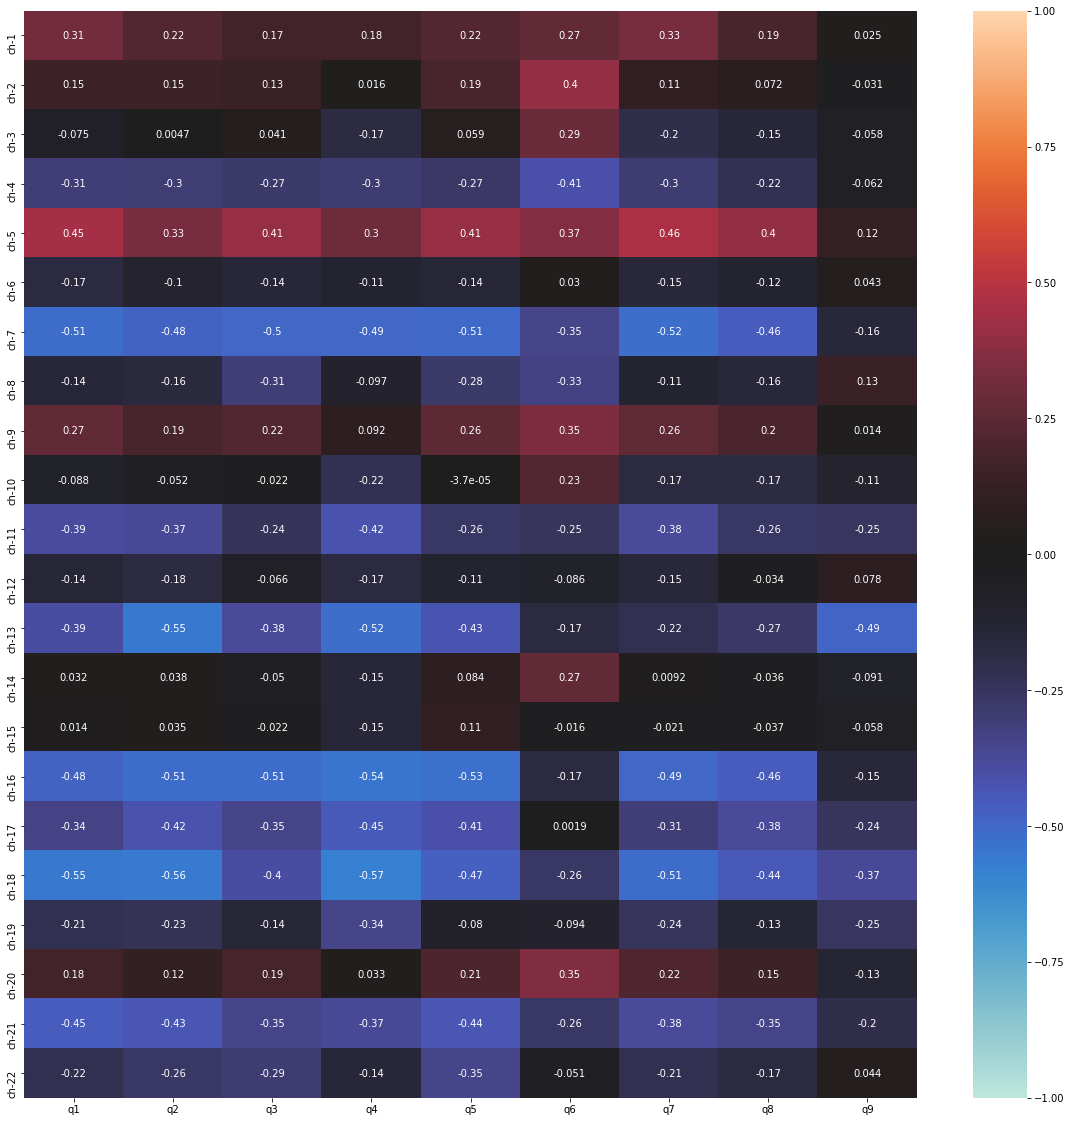



Oxy-Hb variations(task start - task end) with questionnaire results


,trial_count,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,ch-8,ch-9,...,image,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,1,-0.016711,-0.018787,-0.003243,-0.000760,-0.023108,-0.003696,0.020450,0.005778,-0.020833,...,0713_1.jpg,5,5,5,5,5,4,5,5,3
1,2,0.004319,0.004098,0.006688,0.026713,0.007513,0.010188,0.011715,0.009787,-0.001199,...,0713_2.jpg,3,3,3,3,3,3,3,2,3
2,3,-0.004570,0.001793,0.014639,0.004203,-0.005879,0.011797,0.013118,-0.008272,0.003460,...,0713_3.jpg,2,2,3,2,3,3,3,2,1
3,4,-0.012857,-0.008530,-0.018452,-0.004535,-0.018215,0.010739,0.000828,-0.011464,-0.025825,...,0713_4.jpg,2,2,3,2,3,3,2,2,2
4,5,-0.004779,0.000918,-0.012516,0.008292,0.001672,0.008578,-0.000310,-0.003718,-0.007819,...,0713_5.jpg,4,4,4,4,4,4,4,4,4
5,6,-0.007606,-0.016836,-0.017412,-0.000289,-0.019573,0.009714,-0.011496,0.008163,-0.022007,...,0713_6.jpg,5,5,5,5,5,3,5,5,4
6,7,0.025145,0.012820,-0.000267,0.000402,-0.010984,0.007653,0.028915,0.021206,0.010036,...,0713_7.jpg,3,4,4,4,4,3,3,3,3
7,8,-0.001616,-0.001331,-0.006608,-0.001418,-0.017959,0.004790,0.002363,-0.008286,-0.009216,...,0713_8.jpg,2,1,2,2,2,2,3,2,1
8,9,0.024911,0.014916,0.017099,0.015382,-0.011555,0.015285,0.028279,0.029394,0.006896,...,0713_9.jpg,1,1,3,2,2,3,2,1,1
9,10,0.028414,0.011611,-0.011172,-0.002340,0.005964,0.001641,0.005098,0.017365,0.016095,...,0713_10.jpg,4,4,4,4,4,4,4,4,4




Correlations between questionnaire results and Oxy-Hb variations(task start - task end)


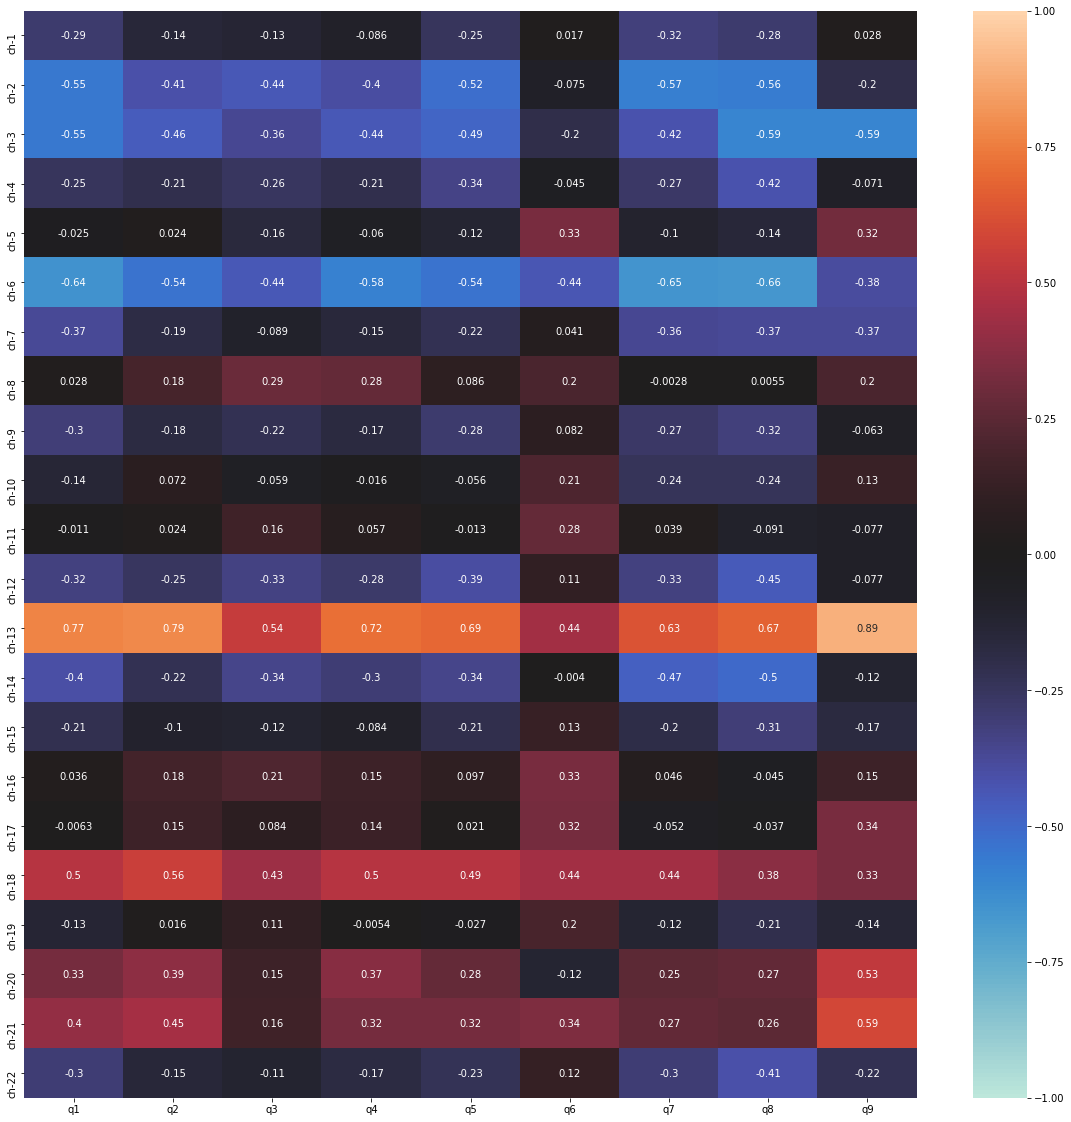

In [82]:
# define constants.
measurement_period = 0.15     # [sec]
preceding_rest_duration = 45  # [sec]
task_duration = 30            # [sec]
following_rest_duration = 45  # [sec]
num_preceding_rest_samples = int(preceding_rest_duration/measurement_period)
num_task_samples = int(task_duration/measurement_period)
num_following_rest_samples = int(following_rest_duration/measurement_period)
num_trial_samples = num_preceding_rest_samples + num_task_samples + num_following_rest_samples
num_columns = 70
separation_char = '\t'
data_table_start_row_index = 33
# marker_string = "1"
nirs_data_filepath = './experimental_data/nirs/0713-main.TXT'
questionnaire_data_filepath = './experimental_data/questionnaire/0713.csv'

# load nirs data and make (temporary) dataframe object
temporary_names = np.arange(num_columns).astype(str)
temporary_df = pd.read_csv(nirs_data_filepath, names=temporary_names, sep=separation_char)
# print("temporary dataframe")
# display(temporary_df)

# load questionnare data and create dataframe object
questionnaire_result_df = pd.read_csv(
    questionnaire_data_filepath, 
    index_col=0, 
)
questionnaire_contents = questionnaire_result_df.columns.values[1:]
questionnaire_result_df.insert(0, 'trial_count', (np.arange(len(questionnaire_result_df))+1).astype(str))
questionnaire_ids = ['q{}'.format(i+1) for i in range(questionnaire_contents.shape[0])]
mapper = {}
for questionnaire_content, questionnaire_id in zip(questionnaire_contents, questionnaire_ids):
    mapper[questionnaire_content] = questionnaire_id
questionnaire_result_df = questionnaire_result_df.rename(columns=mapper)
questionnaire_content_df = pd.DataFrame(
    np.expand_dims(questionnaire_contents, axis=0), 
    columns=questionnaire_ids
)
print('\n\nQuestionnaire results')
display(questionnaire_result_df)
print('\n\nQuestionnaire contents')
display(questionnaire_content_df)

# create dataframe object that contains oxy-hb data
oxy_data = temporary_df[[temporary_names[0], temporary_names[2], *temporary_names[4::3]]][data_table_start_row_index:].values
channel_names = [label.replace(' ', '') for label in oxy_data[0][2:]]
oxy_df_column_labels = [*oxy_data[1][:2], *channel_names]
oxy_df = pd.DataFrame(oxy_data[2:], columns=oxy_df_column_labels)
cast_dict = {}
for channel_name in channel_names:
    cast_dict[channel_name] = float
oxy_df = oxy_df.astype(cast_dict)
# find marker indexes
finding_marker_query_statement = 'Mark !=0 and Mark !="0"'
marker_indexes = oxy_df.query(finding_marker_query_statement).index.values
marker_differences = marker_indexes[1:] - marker_indexes[:-1]
valid_marker_boolean_indexes = [*(marker_differences > num_trial_samples), True]
marker_indexes = marker_indexes[valid_marker_boolean_indexes]
num_trials = marker_indexes.shape[0]
# print('\n\nMarker indexes -> {}'.format(marker_indexes))
# add two columns('trial_count', 'trial_category') to oxy_df
# to do this, you can access data easily 
trial_counts = np.zeros(len(oxy_df))
trial_categories = np.full(len(oxy_df), '', dtype=object)
for i, marker_index in enumerate(marker_indexes):
    trial_counts[marker_index:] = i+1
    trial_categories[marker_index:marker_index+num_preceding_rest_samples] = 'preceding_rest'
    trial_categories[marker_index+num_preceding_rest_samples:marker_index+num_preceding_rest_samples+num_task_samples] = 'task'
    trial_categories[marker_index+num_preceding_rest_samples+num_task_samples:marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples] = 'following_rest'
    trial_categories[marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples:] = 'questionnaire'
oxy_df.insert(1, 'trial_count', trial_counts.astype(int))
oxy_df.insert(2, 'trial_category', trial_categories)
oxy_df = oxy_df.drop('Mark', axis=1)
oxy_df = oxy_df.rename(columns={'Time(sec)': 'time'})
print('\n\nOxy-Hb data')
display(oxy_df)

# denoise data 
# to denoise data, use multi resolution analysis
oxy_df_column_labels = oxy_df.columns.values
info_labels = oxy_df_column_labels[:3]
oxy_value_labels = oxy_df_column_labels[3:]
info_values = oxy_df[info_labels].values
oxy_values = oxy_df[oxy_value_labels].values.astype(float).T
num_paddings = 2**14-oxy_values.shape[1]
wavelet_input = np.pad(oxy_values, [(0,0),(0,num_paddings)])
count = 0
period = 0.15
frequency = 1/period
denoised_oxy_values = np.zeros(wavelet_input.shape)
resample_x = np.linspace(0, wavelet_input.shape[1], wavelet_input.shape[1])
while wavelet_input.shape[1] > 10:
    count += 1
    period *= 2
    frequency = 1/period
    wavelet_output = wavelet_input[:, 0::2] + (wavelet_input[:, 1::2] - wavelet_input[:, 0::2])/2
    wavelet_input = wavelet_output
    if 0.004 < frequency and frequency < 0.1:
        resampled_wavelet_output = np.zeros(denoised_oxy_values.shape)
        for i, wavelet_output_per_channel in enumerate(wavelet_output):
            x = np.linspace(0, resample_x.shape[0], wavelet_output_per_channel.shape[0])
            interpolated_wavelet_output_per_channel = interpolate.interp1d(x, wavelet_output_per_channel, kind='cubic')
            resampled_wavelet_output[i] = interpolated_wavelet_output_per_channel(resample_x)
#         print('period -> {}'.format(period))
#         print('frequency -> {}'.format(frequency))
#         print('resampled_wavelet_output -> {}'.format(resampled_wavelet_output.shape))
#         plt.plot(resampled_wavelet_output[0])
#         plt.show()
        denoised_oxy_values += resampled_wavelet_output
denoised_oxy_values = np.hstack([info_values, denoised_oxy_values.T[:-num_paddings]])
denoised_oxy_df = pd.DataFrame(
    denoised_oxy_values,
    columns=oxy_df_column_labels
)
print('\n\nDenoised Oxy-Hb data')
display(denoised_oxy_df)

# for each trial, caluculate z-scores of task samples and create dataframe.
z_normalized_task_samples_list = []
means_list = []
variations_list = []
task_infomations_list = []
for trial_count in range(1, num_trials+1):
    query_statement = 'trial_count == {}'.format(trial_count)
    oxy_df_while_trial = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "preceding_rest"'.format(trial_count)
    oxy_df_while_preseding_rest = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "task"'.format(trial_count)
    oxy_df_while_task = denoised_oxy_df.query(query_statement)
    task_infomations = oxy_df_while_task[info_labels].values
    task_infomations_list.append(task_infomations)
    task_samples = oxy_df_while_task[oxy_value_labels].values.astype(float).T
    task_sample_means = np.mean(task_samples, axis=1)
    task_sample_stds = np.std(task_samples, axis=1)
    z_normalized_task_samples = np.zeros(task_samples.shape)
    for i in range(task_samples.shape[0]):
        z_normalized_task_samples[i] = (task_samples[i]-task_sample_means[i])/task_sample_stds[i]
    z_normalized_task_samples_list.append(z_normalized_task_samples)

    # visualize data
    print('\n\nTrial count -> {}'.format(trial_count))
    fig = plt.figure(figsize=(20,10))
    second_row_start_index = 7
    third_row_start_index = 15
    for i, channel_label in enumerate(oxy_value_labels):
        samples = oxy_df_while_trial[channel_label].values[:num_trial_samples]
        times = np.linspace(0, 120, samples.shape[0])
        if i < second_row_start_index :
            ax = plt.subplot2grid((3, 16), (0, 2*i+1), rowspan=1, colspan=2)
        elif second_row_start_index <= i and i <= 14:
            ax = plt.subplot2grid((3, 16), (1, 2*(i-second_row_start_index)), rowspan=1, colspan=2)
        elif third_row_start_index <= i:
            ax = plt.subplot2grid((3, 16), (2, 2*(i-third_row_start_index)+1), rowspan=1, colspan=2)
        ax.plot(times, samples)
        ax.axvline(x=times[num_preceding_rest_samples], color='green')
        ax.axvline(x=times[num_preceding_rest_samples+num_task_samples], color='green')
        ax.set_title(channel_label)
    plt.show()
    all_channel_samples = oxy_df_while_task[oxy_value_labels].values.T
    means = np.mean(all_channel_samples, axis=1)
    means_list.append(means)
    variations = all_channel_samples[:, -1] - all_channel_samples[:, 0]
    variations_list.append(variations)
    reshaped_means = np.zeros([3, 16])
    reshaped_means[0,1:15:2] = means[:7]
    reshaped_means[0,2:16:2] = means[:7]
    reshaped_means[1,0::2] = means[7:15]
    reshaped_means[1,1::2] = means[7:15]
    reshaped_means[2,1:15:2] = means[15:]
    reshaped_means[2,2:16:2] = means[15:]
    plt.figure(figsize=(20,10))
    plt.imshow(reshaped_means+1, cmap='bwr')
    plt.show()

z_normalized_task_samples_array = np.reshape(np.array(z_normalized_task_samples_list), [2000, 22])
task_infomations_array = np.reshape(np.array(task_infomations_list), [2000, 3])
z_normalized_task_sample_df = pd.DataFrame(
    np.hstack([task_infomations_array, z_normalized_task_samples_array]),
    columns=oxy_df_column_labels
)
print('\n\nZ-normalized Oxy-Hb data')
display(z_normalized_task_sample_df)

means_array = np.array(means_list).astype(float)
mean_df = pd.DataFrame(
    means_array,
    columns=oxy_value_labels
)
mean_df.insert(0, 'trial_count', (np.arange(len(questionnaire_result_df))+1).astype(str))
# print('\n\nOxy-Hb mean')
# display(mean_df)
mean_with_questionnaire_result_df = pd.merge(mean_df, questionnaire_result_df, on='trial_count')
print('\n\nOxy-Hb mean with questionnaire results')
display(mean_with_questionnaire_result_df)
print('\n\nCorrelations between questionnaire results and Oxy-Hb mean values')
questionnaire_and_mean_correlations = mean_with_questionnaire_result_df.corr()[questionnaire_result_df.columns.values[2:]][:22]
plt.figure(figsize=(20,20))
sns.heatmap(questionnaire_and_mean_correlations, vmax=1, vmin=-1, center=0, annot=True)
plt.show()


variations_array = np.array(variations_list).astype(float)
variation_df = pd.DataFrame(
    variations_array,
    columns=oxy_value_labels
)
variation_df.insert(0, 'trial_count', (np.arange(len(variation_df))+1).astype(str))
variation_with_questionnaire_result_df = pd.merge(variation_df, questionnaire_result_df, on='trial_count')
print('\n\nOxy-Hb variations(task start - task end) with questionnaire results')
display(variation_with_questionnaire_result_df)
print('\n\nCorrelations between questionnaire results and Oxy-Hb variations(task start - task end)')
questionnaire_and_variation_correlations = variation_with_questionnaire_result_df.corr()[questionnaire_result_df.columns.values[2:]][:22]
plt.figure(figsize=(20,20))
sns.heatmap(questionnaire_and_variation_correlations, vmax=1, vmin=-1, center=0, annot=True)
plt.show()
    